# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2018-CS109A/blob/master/content/styles/iacs.png?raw=true"> CS-S109A Introduction to Data Science 

## Lecture 10: Boosting, Stacking, and ANNs

**Harvard University**<br>
**Summer 2020**<br>
**Instructors:** Kevin Rader<br>
**Authors:** Rahul Dave, David Sondak, Pavlos Protopapas, Chris Tanner, Eleni Kaxiras, Kevin Rader

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

# Table of Contents 
<ol start="0">
<li> Learning Goals </li>
<li> Basic Boosting </li> 
<li> AdaBoost </li> 
<li> Basics of Artificial Neural Networks (ANNs) </li> 
    

## Learning Goals

This Jupyter notebook accompanies Lecture 10. By the end of this lecture, you should be able to:

- understand the basic idea of boosting as an esemble method
- use AdaBoost to fit a boosted model for a classification problem
- build and understand a simple artifical neural network (ANN)
- use Keras to build and fit complex ANNs automatically


In [2]:
%matplotlib inline
import sys
import numpy as np
import pylab as pl
import pandas as pd
import sklearn as sk
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn import tree
from sklearn import ensemble

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.decomposition import PCA
import sklearn.metrics as met

from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 20)
plt.rcParams["figure.figsize"] = (12,8)

## Part 0: Data Creation

We will be using artificial data throughout this notebook for pedagogical reasons.  First we create some  classification response data based on pseudo-GPS coordinates:

In [3]:
# create coordinates, then response based on those coordinates
np.random.seed(109)
data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=1000)
data = np.hstack((data, np.zeros((1000, 1))))
data[data[:, 0]**2 + data[:, 1]**2 < 3**2, 2] = 1

In [4]:
pd.DataFrame(data).head()

,0,1,2
0,-0.419788,5.457430,0.0
1,-2.103934,1.372748,1.0
2,1.644911,2.175511,1.0
3,0.579578,-0.165637,1.0
4,-0.397322,-1.875488,1.0


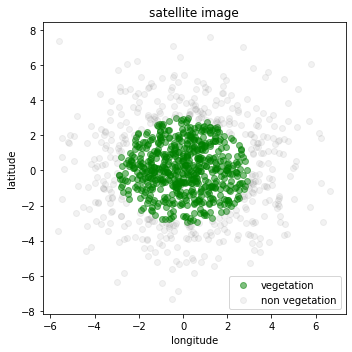

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
x = data[:, :-1]
y = data[:, -1]
ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation', alpha=0.5)
ax.scatter(x[y == 0, 0], x[y == 0, 1], c='gray', label='non vegetation', alpha=0.1)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('satellite image')
ax.legend()
plt.tight_layout()
plt.show() 

## Part 1: Comparing Boosting to other tree-based Models

We give you a lot of code below to estimate 4 different tree-based models (none of which are tuned, for computational efficiency purposes).  Each has been recalculated for 5 separate re-creations of the data:

- A single decision tree (depth = 10)
- A Bagging model (with 20 base trees, default other parameters)
- A Random Forest model (with 20 base trees, default other parameters)
- A Boosted model (with 20 base trees each with a depth of 2)


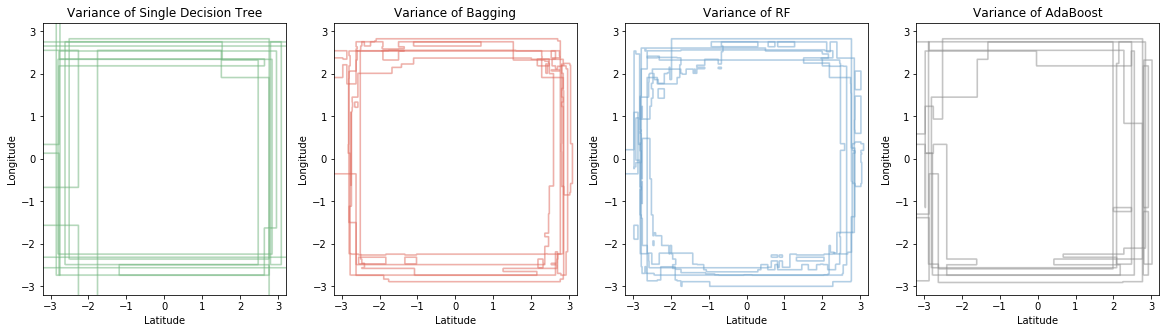

In [6]:
def fit_and_plot_dt(x, y, depth, title, ax, plot_data=True, fill=True, color='Greens'):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax, plot_data, fill, color)
    
    return ax


def plot_tree_boundary(x, y, model, title, ax, plot_data=True, fill=True, color='Greens', alpha=0.1):
    if plot_data:
        # PLOT DATA
        ax.scatter(x[y==1,0], x[y==1,1], c='green')
        ax.scatter(x[y==0,0], x[y==0,1], c='white')
    
    # CREATE MESH
    interval = np.arange(min(x.min(), y.min()),max(x.max(), y.max()),0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    if fill:
        ax.contourf(x1, x2, yy, alpha=alpha, cmap=color)
    else:
        ax.contour(x1, x2, yy, alpha=alpha, cmap=color)
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax


#Variance reduction: Baggining, RF, Tree, Adaboost
depth = 10

fig, ax = plt.subplots(1, 4, figsize=(20, 5))


for i in range(5):
    new_data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=100)
    new_data = np.hstack((new_data, np.zeros((100, 1))))
    new_data[new_data[:, 0]**2 + new_data[:, 1]**2 < 3**2, 2] = 1
    x = new_data[:, :-1]
    y = new_data[:, -1]

    ax[0] = fit_and_plot_dt(x, y, depth, 'Variance of Single Decision Tree', ax[0], plot_data=False, fill=False)
    
    bag = ensemble.BaggingClassifier(n_estimators=20)
    bag.fit(x, y)
    ax[1] = plot_tree_boundary(x, y, bag, 'Variance of Bagging', ax[1], plot_data=False, fill=False, color='Reds')
    
    rf = ensemble.RandomForestClassifier(n_estimators=20)
    rf.fit(x, y)
    ax[2] = plot_tree_boundary(x, y, rf, 'Variance of RF', ax[2], plot_data=False, fill=False, color='Blues')

    adaboost = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=2), n_estimators=20)
    adaboost.fit(x, y)
    ax[3] = plot_tree_boundary(x, y, adaboost, 'Variance of AdaBoost', ax[3], plot_data=False, fill=False, color='Greys')
    
ax[0].set_xlim(-3.2, 3.2)
ax[0].set_ylim(-3.2, 3.2)
ax[1].set_xlim(-3.2, 3.2)
ax[1].set_ylim(-3.2, 3.2)
ax[2].set_xlim(-3.2, 3.2)
ax[2].set_ylim(-3.2, 3.2)
ax[3].set_xlim(-3.2, 3.2)
ax[3].set_ylim(-3.2, 3.2)
plt.show() 

**Q1.1** Assess the 4 plots above.  Which type of model is best able to capture the true decision boundary (that is truly circular).  How could they each be improved?

**Solution:** 

None of the decision boundaries are perfect, but the random forest model recovers/rounds the corners better than the others (which means it has the least bias).  This is not surprising as the splits are less correlated/similar from one tree to the next.  They all could be improved with some tuning (using cross-validatoin).  Note: AdaBoost may outperform the others with more tuning.  



**Q1.2** Assess the computational time it takes for the random forest and bagging models above take to be fit (just use the data given below (note: we add more 'noise' to the data) and the hints for calculating computational time).  

In [7]:
n = 1000
new_data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=n)
new_data = np.hstack((new_data, np.zeros((n, 1))))
new_data[new_data[:, 0]**2 + new_data[:, 1]**2 + np.random.normal(loc=0,scale=10,size=n) < 3**2, 2] = 1
x = new_data[:, :-1]
y = new_data[:, -1]

import time

start_time = time.process_time() 

rf = ensemble.RandomForestClassifier(n_estimators=100)
rf.fit(x, y)

rf_time_elapsed = time.process_time() - start_time

print("Random Forest took",np.round(rf_time_elapsed,4),"seconds.")


start_time = time.process_time() 

adaboost = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=2), n_estimators=100)
adaboost.fit(x, y)

boost_time_elapsed = time.process_time() - start_time

print("AdaBoost took",np.round(boost_time_elapsed,4),"seconds.")


Random Forest took 0.2376 seconds.
AdaBoost took 0.1648 seconds.


## Part 2: AdaBoost

We started using [`ensemble.AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), but this section shows how it behaves with changing the base tree depth and the number of trees used (using the last version of x and y as the data).

The code below calcaultes a boosted model using base trees of depth 2 (as above) for ensembling 100 tree together.  Then the cumulative predictive behavior is plotted as the depth increases:

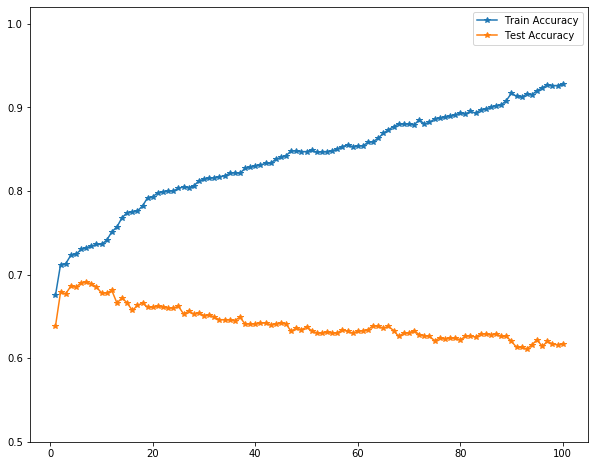

In [8]:
test_data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=n)
test_data = np.hstack((test_data, np.zeros((n, 1))))
test_data[test_data[:, 0]**2 + test_data[:, 1]**2 + np.random.normal(loc=0,scale=10,size=n) < 3**2 , 2] = 1
x_test = test_data[:, :-1]
y_test = test_data[:, -1]

n_trees = 100
depth = 2
learnrate = 1

adaboost = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=depth), n_estimators=n_trees, learning_rate=learnrate)
adaboost.fit(x, y)

acc_train = list(adaboost.staged_score(x,y))
acc_test = list(adaboost.staged_score(x_test,y_test))
plt.figure(figsize=(10, 8))
plt.plot(range(1,n_trees+1),acc_train,'*-',label="Train Accuracy")
plt.plot(range(1,n_trees+1),acc_test,'*-',label="Test Accuracy")
plt.ylim(0.5,1.02)
plt.legend();


**Q2.1** What do you notice in the plot above? When does this boosted model start to overfit?  

**Solution:**

This plot illustrates that any booted model tends to overfit to the training set (accuracy approaches 100%) the more base trees are used.  The test set's accuracy really starts to drop off after 20 or so base trees are used (and the gap between train and test widens).

**Q2.2** What are the 3 parameters that can be tuned in a boosted model?  How would this boosted model predicted ability change if each of the 3 parameters were changed (one at a time)?

**Solution:**

The 3 parameters are:
- The number of base trees (`n_estimators`): this would lead to overfitting when it is increased beyond the default use of 100 here, unless the learning rate was very small.
- The complexity of each base tree (`max_depth`): the smaller this would be, the more freedom we would have to add more trees to the model without overfitting.  But too small (if it were 1), then the model would never be specific enough out in the tails of the predictors, or may only ever use one predictor to do the splits.
- The learning rate of the gradient boosting (`learning_rate`): too big and then may skip over a better combination of mutiple tree rather than a single tree.  Too small, and then finding the optimum may rely on too many base trees to be useful.

**Q2.3** Use the framework above to add a new boosted classifier to the plot.  Play around with the parameters of the boosted model to try to improve the predictive ability on the test set.  

The original boosted tree had a max accuracy on the test set of 0.691 ,which occurred when boosting 6 trees.
The updated boosted tree had a max accuracy on the test set of 0.719 ,which occurred when boosting 111 trees.


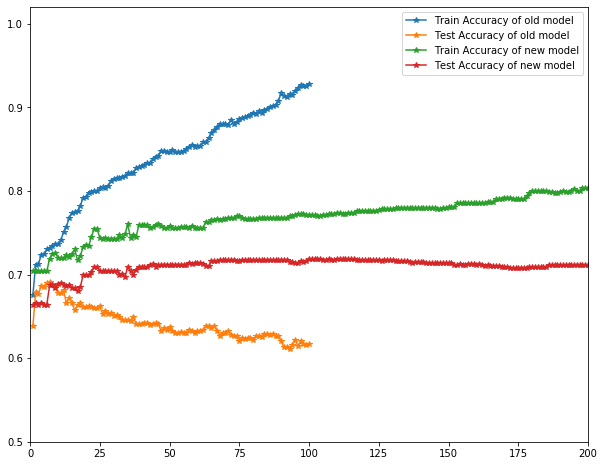

In [9]:
######
# your code here
#####

n_trees_2 = 200
depth = 3
learnrate = 0.01

adaboost2 = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=depth), n_estimators=n_trees_2, learning_rate=learnrate)
adaboost2.fit(x, y)

acc_train_boost2 = list(adaboost2.staged_score(x,y))
acc_test_boost2 = list(adaboost2.staged_score(x_test,y_test))
plt.figure(figsize=(10, 8))
plt.plot(range(1,n_trees+1),acc_train,'*-',label="Train Accuracy of old model")
plt.plot(range(1,n_trees+1),acc_test,'*-',label="Test Accuracy of old model")
plt.plot(range(1,n_trees_2+1),acc_train_boost2,'*-',label="Train Accuracy of new model")
plt.plot(range(1,n_trees_2+1),acc_test_boost2,'*-',label="Test Accuracy of new model")
plt.ylim(0.5,1.02)
plt.xlim(0,np.max([n_trees,n_trees_2]))
plt.legend();

print("The original boosted tree had a max accuracy on the test set of", np.max(acc_test), 
      ",which occurred when boosting",np.argmax(acc_test), "trees.")

print("The updated boosted tree had a max accuracy on the test set of", np.max(acc_test_boost2), 
      ",which occurred when boosting",np.argmax(acc_test_boost2), "trees.")

## Part 3: Basics of Artificial Neural Network

<div class='theme' > Keras and TENSORFLOW 2.0 </div>

In this tutorial we will repeat what we have done in Lecture 18, exercise but now use keras as part of the tensorflow 2.0.

TensorFlow is a framework for representing complicated DNN algorithms and executing them in any platform, from a phone to a distributed system using GPUs. Developed by Google Brain, TensorFlow is used very broadly today. 

**[`keras`](https://keras.io/)**, is a high-level API used for fast prototyping, advanced research, and production. We will use `tf.keras` which is TensorFlow's implementation of the `keras` API.

### Models are assemblies of layers

The core data structure of Keras is a **model**, a way to organize layers. A model is understood as a sequence or a graph of standalone, fully-configurable modules that can be plugged together with as few restrictions as possible. In particular, neural layers, cost functions, optimizers, initialization schemes, activation functions, regularization schemes are all standalone modules that you can combine to create new models.

The simplest type of model is the **Sequential** model, a linear stack of layers. For more complex architectures, one can use the Keras **Functional** API, which allows to build arbitrary graphs of layers.

https://keras.io/models/model/

Everything you need to know about the Sequential model is here: https://keras.io/models/sequential/


### Tensorflow  Installation
Just a quick reminder, in Lecture 18 ex1 and ex2 we combine neurons and we adjusted the weights manually to produce a function that looks like a guassian. In this demo we will first do exactly the same as in the exercise but now use TF. At the end we will ask TF (nicely) to find the weights for us. How this is done behind the scenes will be explained in Lecture 20. For now we are only looking at the mechanics. 

https://www.tensorflow.org/install/

pip install tensorflow=2.0

In [10]:
# usual imports 
import numpy as np
import matplotlib.pyplot as plt

#import tensorflow 
import tensorflow as tf
 
# If it is not installed yet, you can use this:
# pip install --upgrade tensorflow

#### Instructions for running `tf.keras` with Tensorflow 2.0:  

All references to Keras should be written as `tf.keras`.  For example: 

```
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
tf.keras.models.Sequential
tf.keras.layers.Dense, tf.keras.layers.Activation, 
tf.keras.layers.Dropout, tf.keras.layers.Flatten, tf.keras.layers.Reshape
tf.keras.optimizers.SGD
tf.keras.preprocessing.image.ImageDataGenerator
tf.keras.regularizers
tf.keras.datasets.mnist   
```


In [11]:
# You can avoid the long names by using
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [12]:
#check if the correct version of tensorflow is used
tf.__version__

'2.2.0'

## Data Creation
We will be using artificial data for this part of the lab (for pedagogical reasons).  Note: we can always create more data to build a test set later).

We create and visualize the data below:

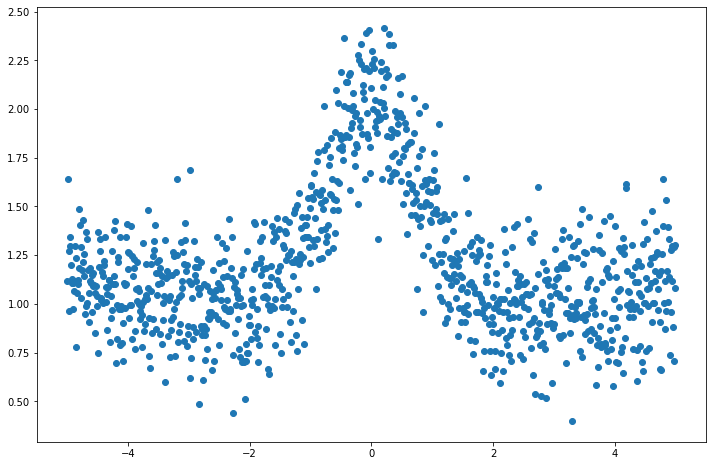

In [13]:
# generate data 

np.random.seed(109)
x2 = np.linspace(-5,5,1000)
y_real = np.exp( - (x2**2)) + np.random.normal(loc=1, scale=0.2, size=x2.shape)+0.00001*(x2**6)
plt.scatter(x2,y_real);

## First model: one neuro 

<img src='../fig/SingleNeuron.png'  height="442" width="442"></img>


Build by hand

In [14]:
#reset the model 

model = models.Sequential()

# hidden layer (and output layer), one neuron 
model.add(layers.Dense(1, activation='sigmoid', input_shape=(1,)))

weights = model.get_weights()
# set the weights by hand as before
weights[0][0]=1       # weight 
weights[1][0]=-0.4    # bias 

model.set_weights(weights)

In [15]:
# check if the network is what we expected
# Summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


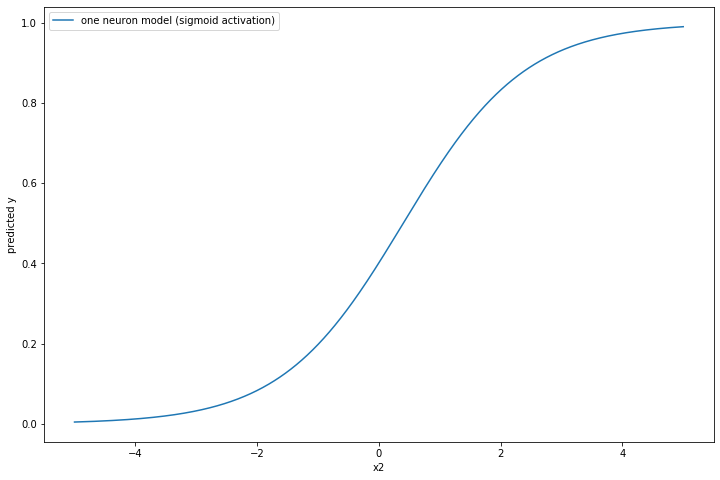

In [16]:
# predict 
y_hat_oneneuron = model.predict(x2)

# plot 
plt.plot(x2,y_hat_oneneuron, label='one neuron model (sigmoid activation)')
plt.xlabel('x2')
plt.ylabel('predicted y')
plt.legend();

### Two layers as 
<img src='../fig/multiple-perceptrons.png'  height="542" width="542"></img>


In [17]:
#reset the model 
model = models.Sequential()

# hiddeb layer with 2 nodes 
model.add(layers.Dense(2, activation='sigmoid', input_shape=(1,)))


# output layer, one neuron 
model.add(layers.Dense(1,  activation='linear'))

#Weights 
weights = model.get_weights()
# hidden layer
weights[0][0]=np.array([ 1.5,-2.4]) #weights 
weights[1]=np.array([-0.4,2.0]) # biases
# output layer 
weights[2]=np.array([[3],[3]]) # weights
weights[3] = np.array([-2])    # bias

model.set_weights(weights)

In [18]:
# Again check the network to make sure is what we expeected 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 4         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


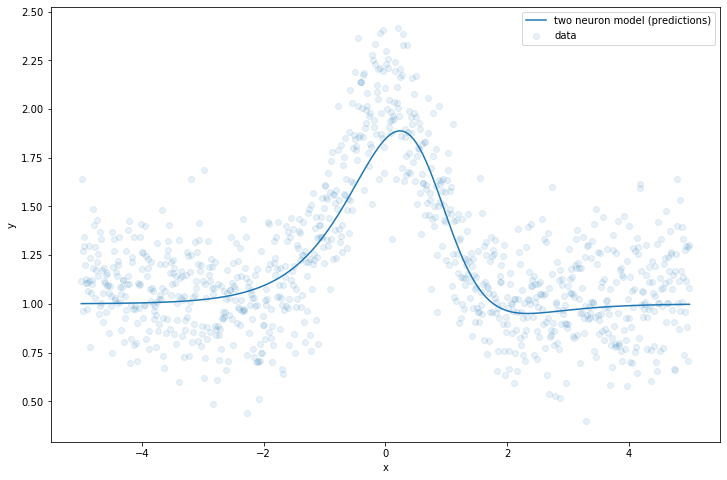

In [19]:
y_hat_twoneurons = model.predict(x2)

plt.scatter(x2, y_real, alpha=0.1, label='data')
plt.plot(x2,y_hat_twoneurons, label='two neuron model (predictions)')

plt.xlabel('x')
plt.ylabel('y')
plt.legend();

## Now let Tensorflow do the job finding the weights 

In [20]:
#reset the model 
model_tf = models.Sequential()

# hidden layer with 2 nodes 
model_tf.add(layers.Dense(2, activation='sigmoid', input_shape=(1,)))


# output layer, one neuron (note: it is a quantitative outpu)
model_tf.add(layers.Dense(1,  activation='linear'))

In [21]:
model_tf.compile(loss='MSE')
history = model_tf.fit(x2,y_real, epochs=500, batch_size=64, verbose=0)

In [22]:
y_hat_tf = model_tf.predict(x2)

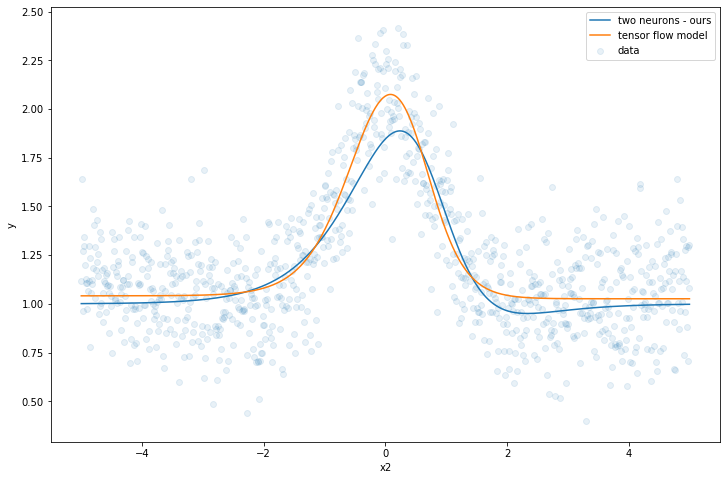

In [23]:
plt.scatter(x2, y_real, alpha=0.1, label='data')
plt.plot(x2,y_hat_twoneurons, label='two neurons - ours')
plt.plot(x2,y_hat_tf, label='tensor flow model')

plt.xlabel('x2')
plt.ylabel('y')
plt.legend();

In [24]:
weights_tf = model_tf.get_weights()

print("TensorFlow weights:\n", weights_tf)
print()
print("my weights:\n", weights)

TensorFlow weights:
 [array([[2.365558 , 3.1155846]], dtype=float32), array([ 1.0213019, -1.9443506], dtype=float32), array([[ 1.6841967],
       [-1.6992313]], dtype=float32), array([1.0410538], dtype=float32)]

my weights:
 [array([[ 1.5, -2.4]], dtype=float32), array([-0.4,  2. ]), array([[3],
       [3]]), array([-2])]


**Q2.1** Assess the accuracy of this quantitative $y$ variable in both the data used to train the model, and based on the newly created test datasets below (there are two of them).

In [25]:
x_test1 = np.linspace(-5,5,1000)
y_test1 = np.exp( - (x_test1**2)) + np.random.normal(loc=1, scale=0.2, size=x_test1.shape)+0.00001*(x_test1**6)
x_test2 = np.linspace(-5,7,1000)
y_test2 = np.exp( - (x_test2**2)) + np.random.normal(loc=1, scale=0.2, size=x_test2.shape)+0.00001*(x_test2**6)

######
# your code here
######
from sklearn.metrics import r2_score 

y_hat_train = model_tf.predict(x2)
y_hat_test1 = model_tf.predict(x_test1)
y_hat_test2 = model_tf.predict(x_test2)

print("Train R-squared:", r2_score(y_real,y_hat_train))
print("Test1 R-squared:", r2_score(y_test1,y_hat_test1))
print("Test2 R-squared:", r2_score(y_test2,y_hat_test2))

Train R-squared: 0.6771137693696975
Test1 R-squared: 0.6639677781240583
Test2 R-squared: 0.2760803667408196


**Q2.2** Recreate the scatterplot of both sets of data (train and test) along with the fitted prediction curve from `model_tf`.  What do you notice?  Why did the model perform poorly on the test set?  

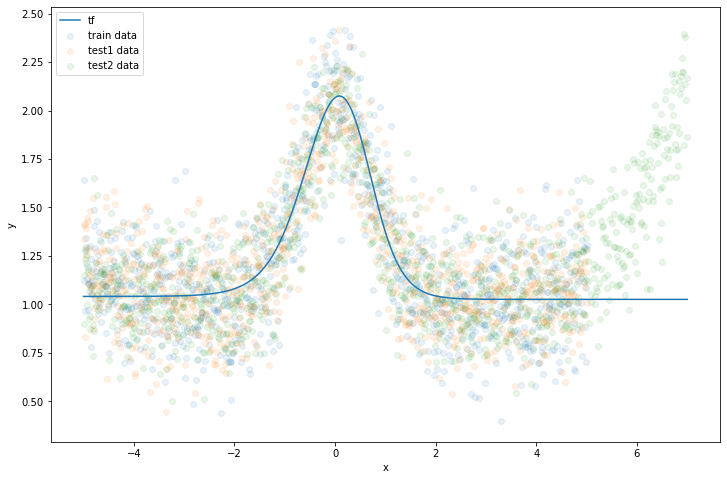

In [26]:
######
# your code here
######
plt.scatter(x2, y_real, alpha=0.1, label='train data')
plt.scatter(x_test1, y_test1, alpha=0.1, label='test1 data')
plt.scatter(x_test2, y_test2, alpha=0.1, label='test2 data')
plt.plot(x_test2,y_hat_test2, label='tf')

plt.xlabel('x')
plt.ylabel('y')
plt.legend();

**Solution:**

The tensor flow model was most accurate on the training set (not surpisingly), was a little less accurate on the first test set, and quite inaccurate in the second test set.  This plot shows why: the first test set was on the same range of predictors as the training set, while the saecond test set .  These predictions were actually extrapolations, and like any statistical or predictive model, there is no reason to think that the estimated signal ($hat{f}(x)$ in a statistical modeling/learning problem) will continue to hold outside the range of data that the model was built on.

**Q2.3** Create an overfit model using TensorFlow (simple to do: just increase the number of layers and/or the number of nodes within layers).  Play around with the activations in the interior layers as well).  Assess how it predicts and behaves on the test sets.  Have you beaten the models above?

In [27]:
######
# Edit code below: this code creates the model above, in one line
######

model_tf2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=(pd.DataFrame(x2).shape[1],), activation='relu'),
    tf.keras.layers.Dense(10, input_shape=(pd.DataFrame(x2).shape[1],), activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='linear'),
])


model_tf2.compile(loss='MSE')
history = model_tf2.fit(x2,y_real, epochs=100, batch_size=64, verbose=0)

In [28]:
y_hat_train = model_tf2.predict(x2)
y_hat_test1 = model_tf2.predict(x_test1)
y_hat_test2 = model_tf2.predict(x_test2)

print("Train R-squared:", r2_score(y_real,y_hat_train))
print("Test1 R-squared:", r2_score(y_test1,y_hat_test1))
print("Test2 R-squared:", r2_score(y_test2,y_hat_test2))

Train R-squared: 0.6885929839129667
Test1 R-squared: 0.6736508567959412
Test2 R-squared: 0.342759798018183


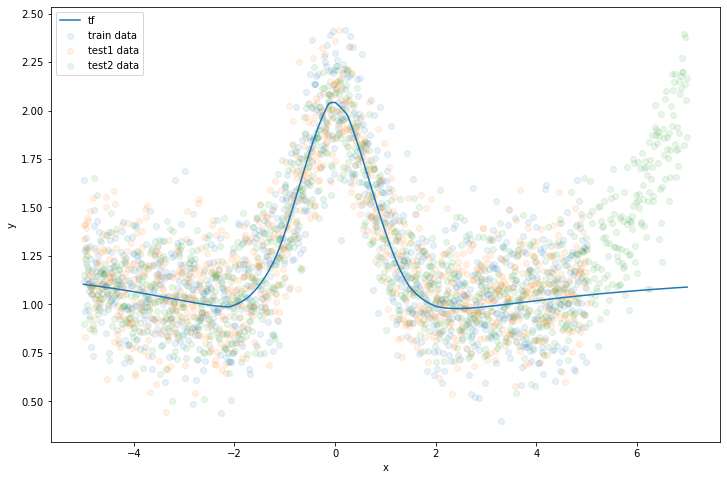

In [29]:
plt.scatter(x2, y_real, alpha=0.1, label='train data')
plt.scatter(x_test1, y_test1, alpha=0.1, label='test1 data')
plt.scatter(x_test2, y_test2, alpha=0.1, label='test2 data')
plt.plot(x_test2,y_hat_test2, label='tf')

plt.xlabel('x')
plt.ylabel('y')
plt.legend();

**Solution:**

This model is way more expressive than the restrictive two-neuron model from before, and is able to capture the slight uptick in the train data at the extremes (though this does not extrapolate well into the non-lniear curve beyond and $x$ of 5).  Thus the predictions are more accurate in the second test set (and similar in the first test set). The combination of 100 'relu' nodes and then 10 'sigmoid' nodes is a good one: the 100 relu nodes can capture a lot of little intracies in the data, and then are smoothed out in the second hidden layer with the 10 sigmoid nodes.

Below we fit an overfit model on the data ():

In [30]:
model_tf3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=(pd.DataFrame(x2).shape[1],), activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])


model_tf3.compile(loss='MSE')
history = model_tf3.fit(x2,y_real, epochs=1000, batch_size=64, verbose=0)

In [31]:
y_hat_train = model_tf3.predict(x2)
y_hat_test1 = model_tf3.predict(x_test1)
y_hat_test2 = model_tf3.predict(x_test2)

print("Train R-squared:", r2_score(y_real,y_hat_train))
print("Test1 R-squared:", r2_score(y_test1,y_hat_test1))
print("Test2 R-squared:", r2_score(y_test2,y_hat_test2))

Train R-squared: 0.7031447056107321
Test1 R-squared: 0.6636060237693855
Test2 R-squared: 0.4757683054975548


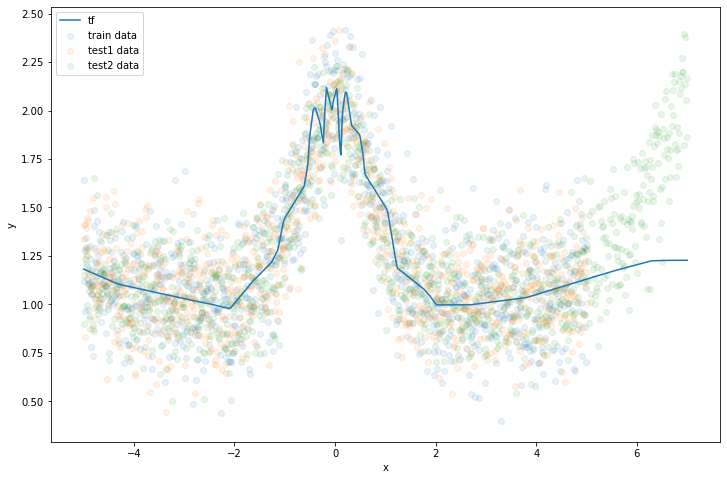

In [32]:
plt.scatter(x2, y_real, alpha=0.1, label='train data')
plt.scatter(x_test1, y_test1, alpha=0.1, label='test1 data')
plt.scatter(x_test2, y_test2, alpha=0.1, label='test2 data')
plt.plot(x_test2,y_hat_test2, label='tf')

plt.xlabel('x')
plt.ylabel('y')
plt.legend();

Note this model has a slightly higher training $R^2$, a slightly lower $R^2$ on the first test set, but actually a higher $R^2$ on the second test set.  The predicted scatterplot above illustrates the overfitting...but it actually extrapolates better than previous models considered into the $x>5$ space.